In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from scipy.stats import zscore

In [2]:
df = pd.read_csv("C:\\Users\\HOME\\Downloads\\crypto\\coin_Bitcoin.csv")
df.head()


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [3]:
df.describe()

,SNo,High,Low,Open,Close,Volume,Marketcap
count,2991.000000,2991.000000,2991.000000,2991.000000,2991.000000,2.991000e+03,2.991000e+03
mean,1496.000000,6893.326038,6486.009539,6700.146240,6711.290443,1.090633e+10,1.208761e+11
std,863.571653,11642.832456,10869.032130,11288.043736,11298.141921,1.888895e+10,2.109438e+11
min,1.000000,74.561096,65.526001,68.504997,68.431000,0.000000e+00,7.784112e+08
25%,748.500000,436.179001,422.879486,430.445496,430.569489,3.036725e+07,6.305579e+09
50%,1496.000000,2387.610107,2178.500000,2269.889893,2286.409912,9.460360e+08,3.741503e+10
75%,2243.500000,8733.926948,8289.800459,8569.656494,8576.238715,1.592015e+10,1.499957e+11
max,2991.000000,64863.098908,62208.964366,63523.754869,63503.457930,3.509679e+11,1.186364e+12


In [4]:
df.drop_duplicates
df.shape

(2991, 10)

In [5]:
df.dtypes

SNo            int64
Name          object
Symbol        object
Date          object
High         float64
Low          float64
Open         float64
Close        float64
Volume       float64
Marketcap    float64
dtype: object

In [6]:
df.isnull().sum()

SNo          0
Name         0
Symbol       0
Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Marketcap    0
dtype: int64

In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values("Date").reset_index(drop=True)


In [8]:
df = df.drop(columns=[col for col in ['SNo', 'Name', 'Symbol'] if col in df.columns])
df['Volume'] = df['Volume'].replace(0, np.nan)
df.interpolate(method='linear', inplace=True)
df.fillna(method='bfill', inplace=True)
df['Target'] = df['Close'].shift(-1)
df.dropna(inplace=True)

C:\Users\HOME\AppData\Local\Temp\ipykernel_20388\1574404754.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


In [9]:
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Marketcap']
z_scores = np.abs(zscore(df[numeric_cols]))
df_cleaned = df[(z_scores < 2.5).all(axis=1)].reset_index(drop=True)

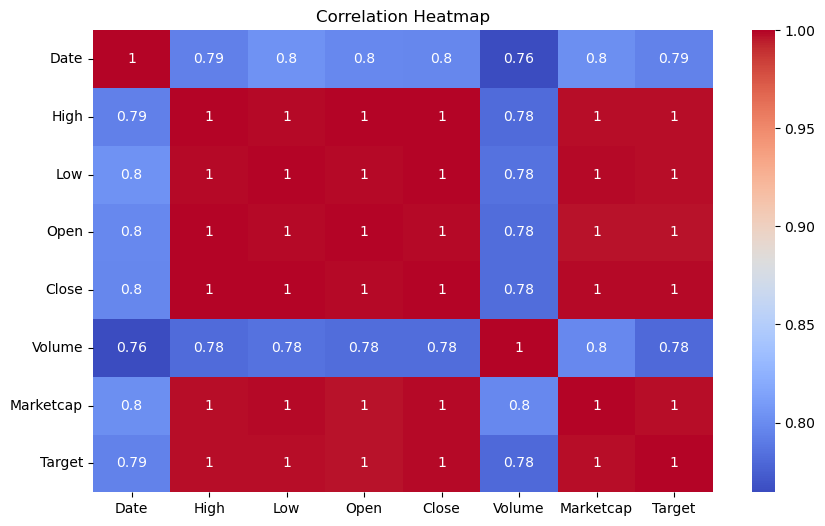

In [10]:
# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_cleaned.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

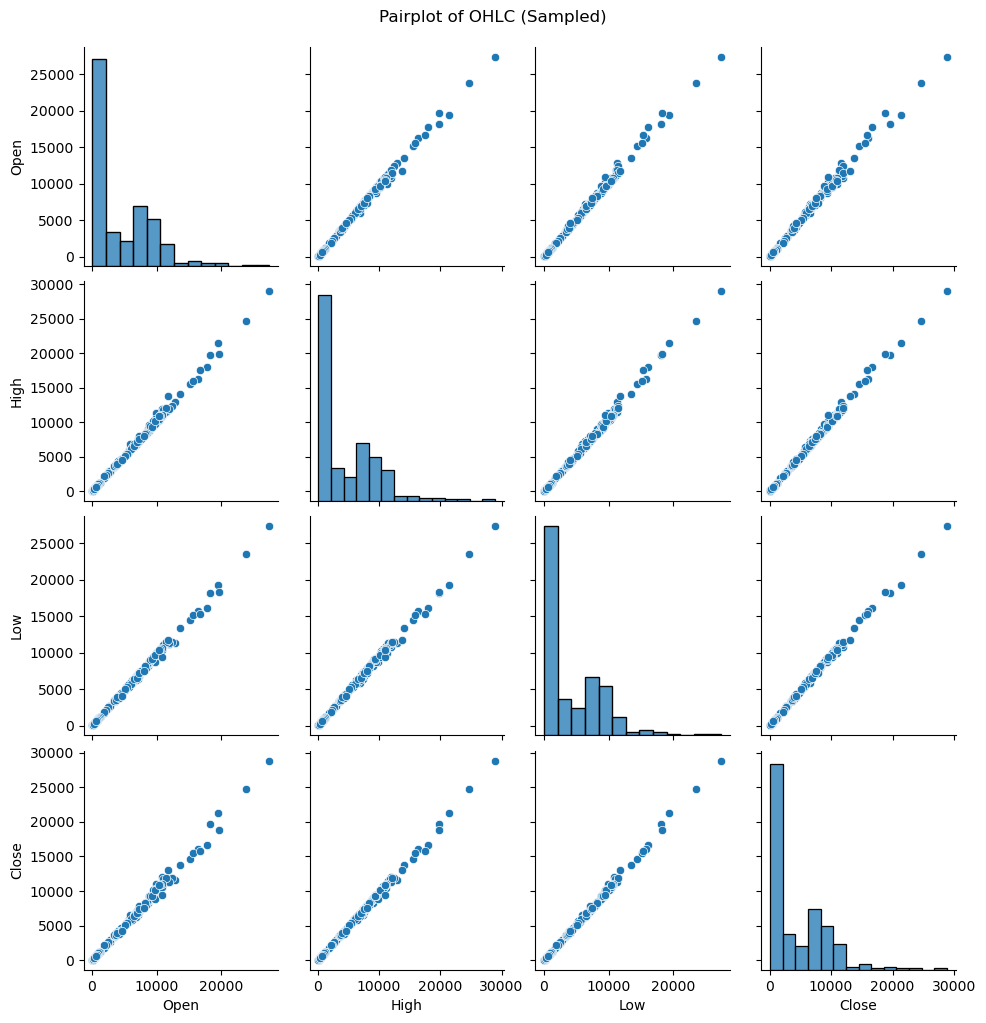

In [11]:
sns.pairplot(df_cleaned[['Open', 'High', 'Low', 'Close']].sample(300))
plt.suptitle("Pairplot of OHLC (Sampled)", y=1.02)
plt.show()

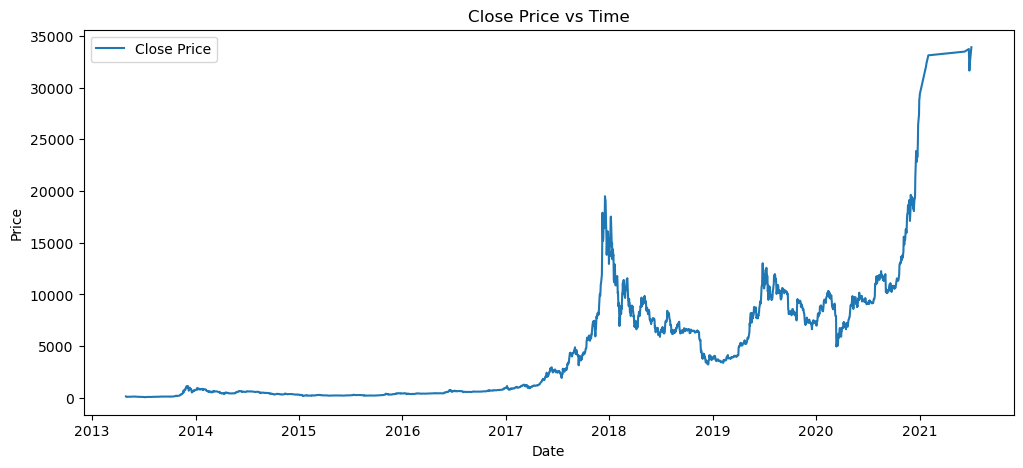

In [12]:
# Close over time
plt.figure(figsize=(12, 5))
plt.plot(df_cleaned['Date'], df_cleaned['Close'], label='Close Price')
plt.title("Close Price vs Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

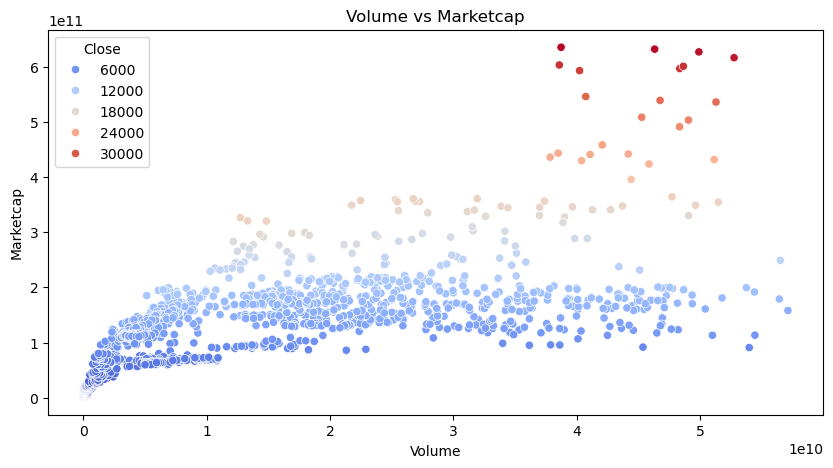

In [13]:
# Volume vs Marketcap
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_cleaned, x='Volume', y='Marketcap', hue='Close', palette='coolwarm')
plt.title("Volume vs Marketcap")
plt.show()

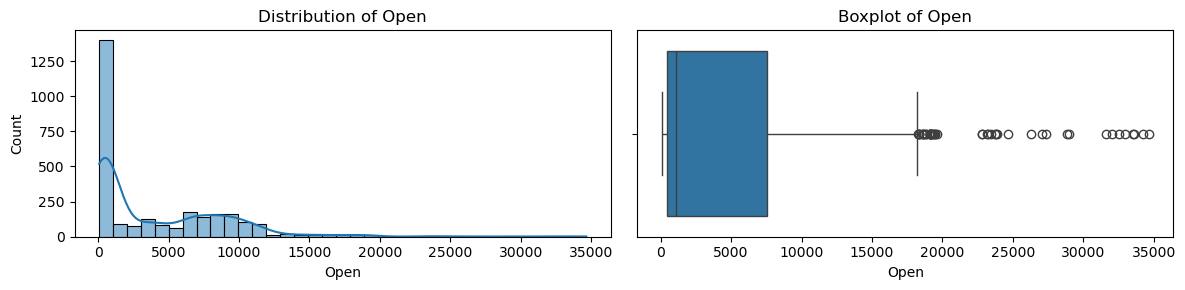

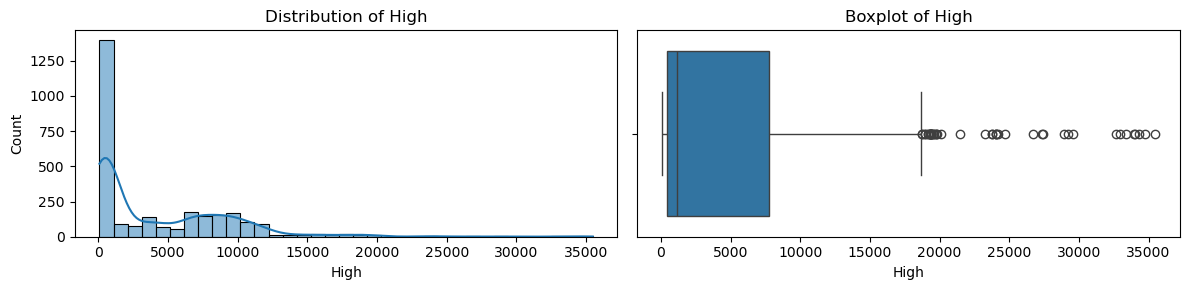

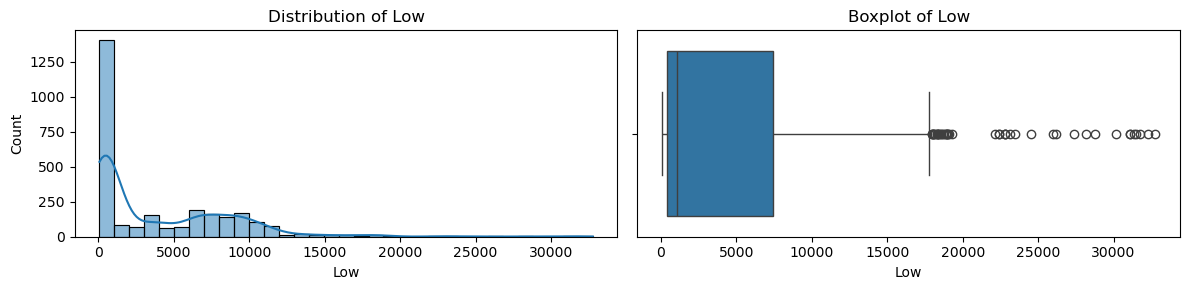

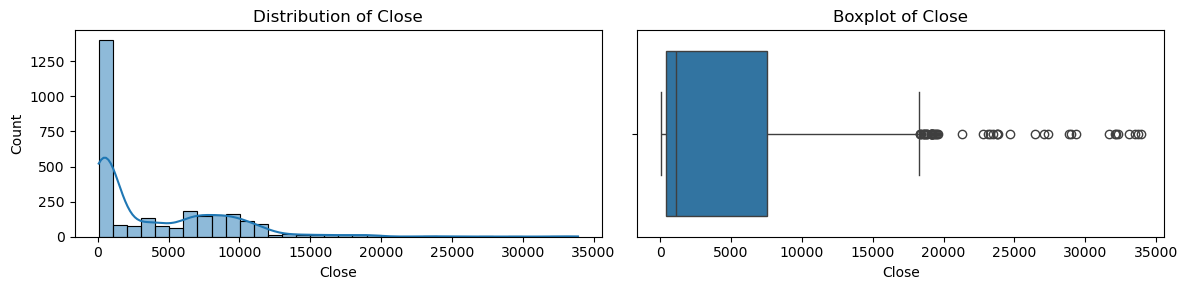

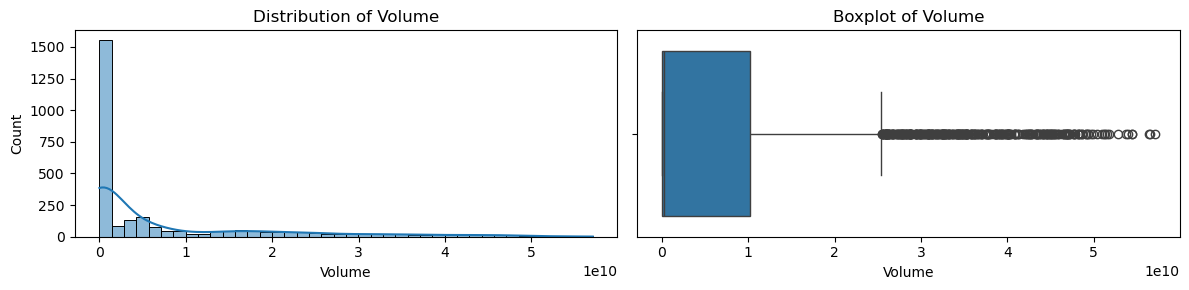

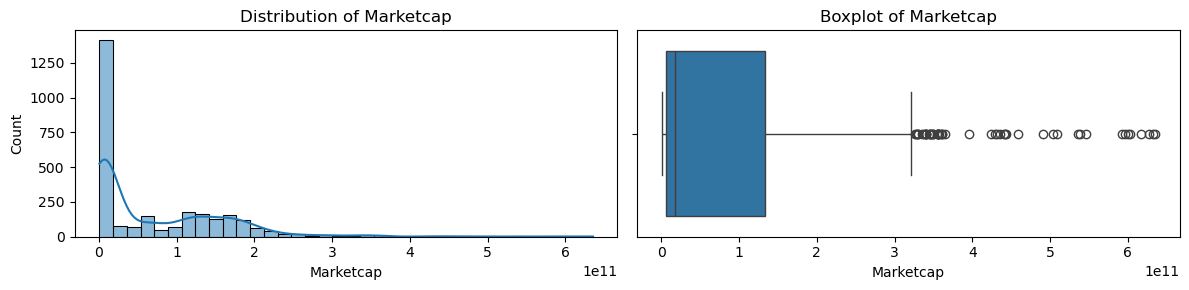

In [14]:
for col in numeric_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))
    sns.histplot(df_cleaned[col], kde=True, ax=axes[0])
    axes[0].set_title(f"Distribution of {col}")
    sns.boxplot(x=df_cleaned[col], ax=axes[1])
    axes[1].set_title(f"Boxplot of {col}")
    plt.tight_layout()
    plt.show()

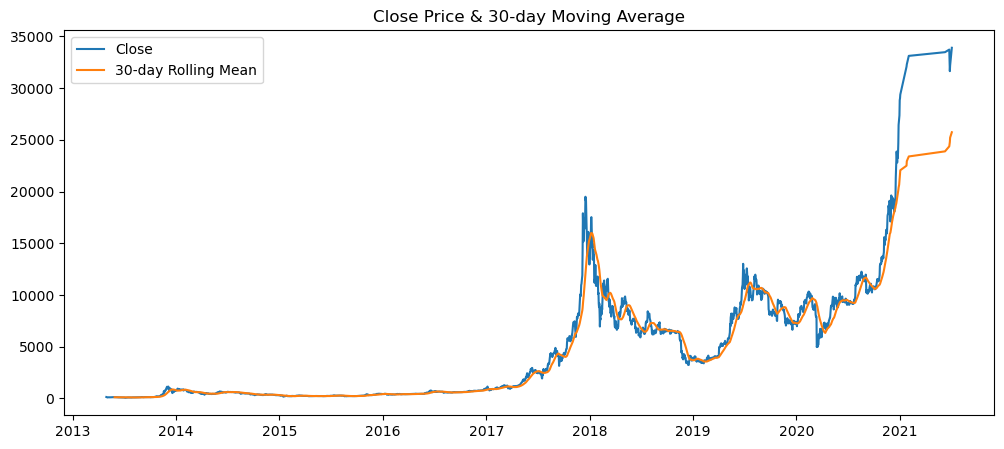

In [15]:
df_cleaned['Rolling_Mean'] = df_cleaned['Close'].rolling(window=30).mean()
plt.figure(figsize=(12, 5))
plt.plot(df_cleaned['Date'], df_cleaned['Close'], label='Close')
plt.plot(df_cleaned['Date'], df_cleaned['Rolling_Mean'], label='30-day Rolling Mean')
plt.title("Close Price & 30-day Moving Average")
plt.legend()
plt.show()

In [ ]:
# 5. Modeling: Prepare Features
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Marketcap']
df_cleaned['Target'] = df_cleaned['Close'].shift(-1)
df_cleaned.dropna(inplace=True)

In [17]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_cleaned[features + ['Target']])
scaled_df = pd.DataFrame(scaled, columns=features + ['Target'])

In [18]:
X_ml = scaled_df[features].values
y_ml = scaled_df['Target'].values
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_ml, y_ml, test_size=0.2, shuffle=False)

In [19]:
#Train ML Models
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train_ml, y_train_ml)
rf_pred = rf.predict(X_test_ml)

xgb = XGBRegressor(n_estimators=100)
xgb.fit(X_train_ml, y_train_ml)
xgb_pred = xgb.predict(X_test_ml)


In [20]:
#  LSTM
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i, :-1])
        y.append(data[i, -1])
    return np.array(X), np.array(y)

X_lstm_all = scaled_df[features + ['Target']].values
X_lstm, y_lstm = create_sequences(X_lstm_all)

split = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split], X_lstm[split:]
y_train_lstm, y_test_lstm = y_lstm[:split], y_lstm[split:]


In [21]:
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

c:\Users\HOME\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=64, validation_split=0.1, verbose=0)
lstm_pred = model_lstm.predict(X_test_lstm)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


In [23]:
#  ARIMA
arima_series = df_cleaned['Close']
train_size = int(len(arima_series) * 0.8)
arima_train, arima_test = arima_series[:train_size], arima_series[train_size:]
arima_model = ARIMA(arima_train, order=(5, 1, 0))
arima_result = arima_model.fit()
arima_pred = arima_result.forecast(steps=len(arima_test))

c:\Users\HOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\HOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\HOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\HOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\HOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, ca

In [25]:
#hybrid model

hybrid_pred = (lstm_pred.flatten()[:len(xgb_pred)] + xgb_pred[:len(lstm_pred)]) / 2

In [27]:
# 10. Evaluation
results = {
    "Random Forest": (mean_squared_error(y_test_ml, rf_pred), r2_score(y_test_ml, rf_pred)),
    "XGBoost": (mean_squared_error(y_test_ml, xgb_pred), r2_score(y_test_ml, xgb_pred)),
    "LSTM": (mean_squared_error(y_test_lstm, lstm_pred), r2_score(y_test_lstm, lstm_pred)),
    "ARIMA": (mean_squared_error(arima_test, arima_pred), r2_score(arima_test, arima_pred)),
    "Hybrid (LSTM + XGBoost)": (mean_squared_error(y_test_ml[:len(hybrid_pred)], hybrid_pred), r2_score(y_test_ml[:len(hybrid_pred)], hybrid_pred)),
}
print("\n🔍 Model Comparison (MSE and R²):")
for model_name, (mse, r2) in results.items():
    print(f"{model_name:<25} MSE: {mse:.5f}  |  R²: {r2:.5f}")


🔍 Model Comparison (MSE and R²):
Random Forest             MSE: 0.00457  |  R²: 0.74587
XGBoost                   MSE: 0.00582  |  R²: 0.67673
LSTM                      MSE: 0.00453  |  R²: 0.75336
ARIMA                     MSE: 19678552.62262  |  R²: -0.00268
Hybrid (LSTM + XGBoost)   MSE: 0.00098  |  R²: 0.90073


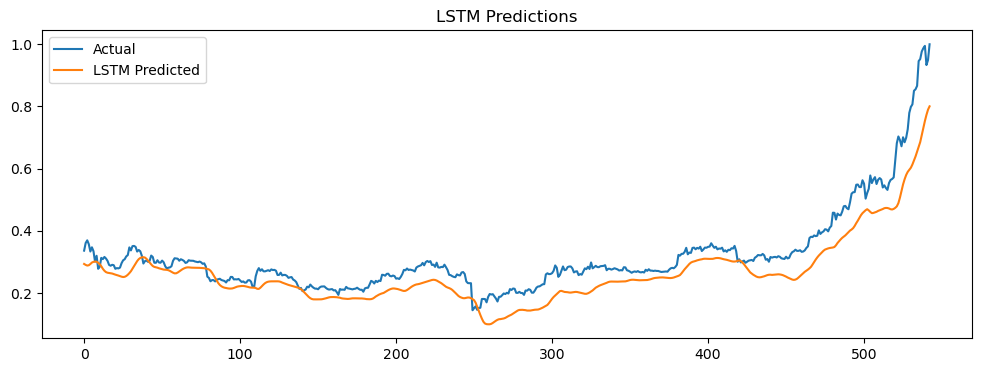

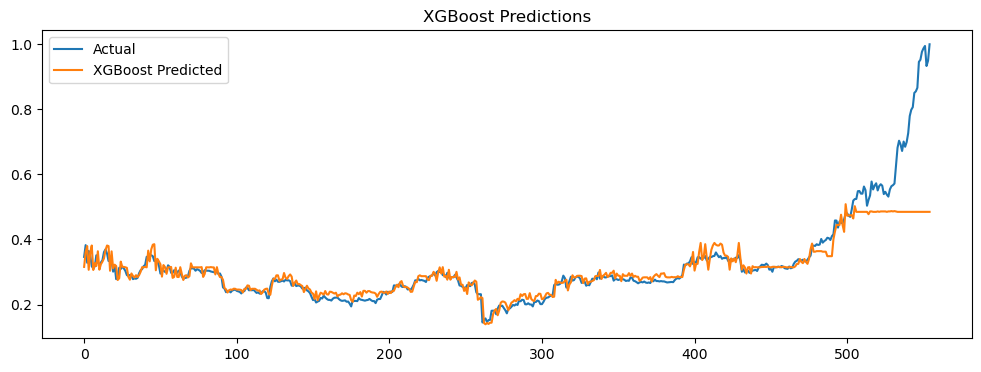

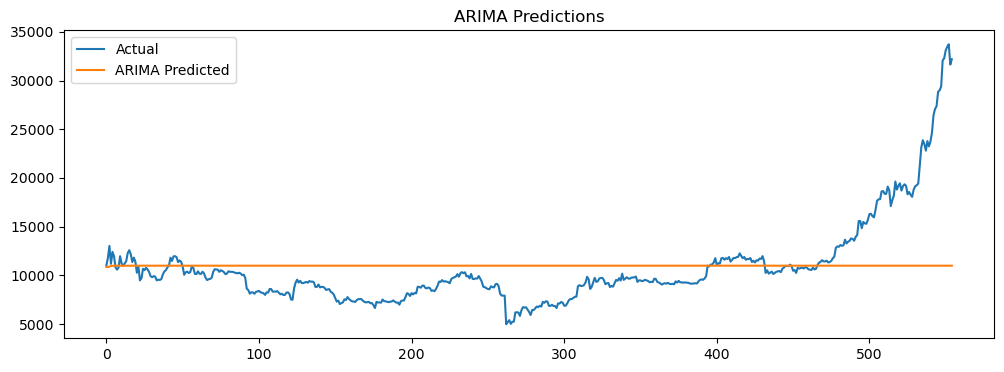

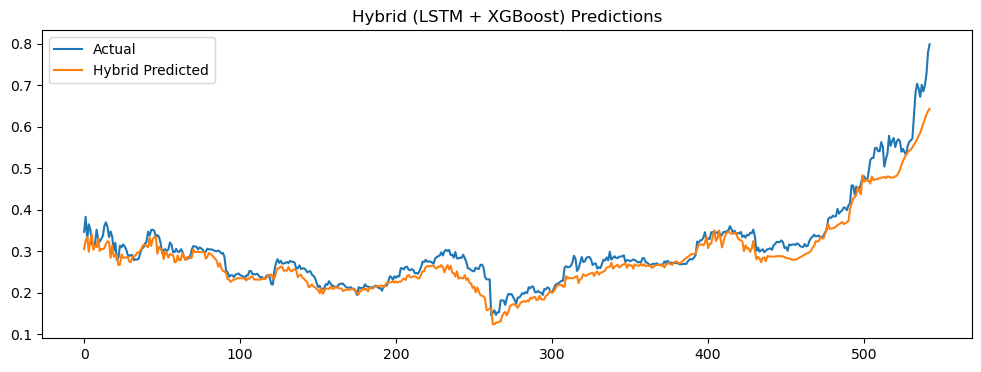

In [28]:
plt.figure(figsize=(12, 4))
plt.plot(y_test_lstm, label='Actual')
plt.plot(lstm_pred, label='LSTM Predicted')
plt.title("LSTM Predictions")
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(y_test_ml, label='Actual')
plt.plot(xgb_pred, label='XGBoost Predicted')
plt.title("XGBoost Predictions")
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(arima_test.values, label='Actual')
plt.plot(arima_pred.values, label='ARIMA Predicted')
plt.title("ARIMA Predictions")
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(y_test_ml[:len(hybrid_pred)], label='Actual')
plt.plot(hybrid_pred, label='Hybrid Predicted')
plt.title("Hybrid (LSTM + XGBoost) Predictions")
plt.legend()
plt.show()
